<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [17]:
import numpy as np
from scipy.spatial.transform import Rotation
import MDAnalysis as mda
from IPython.core.display import display
import matplotlib.pyplot as plt

from molgri.molecules.parsers import FileParser
from molgri.molecules.writers import PtIOManager
from molgri.molecules.transitions import SimulationHistogram
from molgri.space.fullgrid import FullGrid
from molgri.paths import PATH_INPUT_BASEGRO
from molgri.plotting.widgets import ViewManager, display_all_views, sync_all_views
from molgri.space.rotations import two_vectors2rot
from molgri.space.utils import k_argmax_in_array
from molgri.plotting.transition_plots import TransitionPlot

In [3]:
def plot_current_molecule(my_molecule):
    one_universe = mda.Merge(my_molecule.atoms)
    vm = ViewManager(one_universe)
    vm.plot_ith_frame(0)
    return vm.view

In [ ]:
file_path = f"{PATH_INPUT_BASEGRO}H2O"
file_parser = FileParser(file_path)
one_molecule = file_parser.as_parsed_molecule()
# now start doing translations and rotations
fg = FullGrid(b_grid_name="3", o_grid_name="15", t_grid_name="[0.2, 0.4]")
my_array = fg.get_full_grid_as_array()

#view0 = plot_current_molecule(one_molecule)

one_molecule.translate_to_origin()

def my_generator():
    for i, se3_coo in enumerate(my_array):
        position = se3_coo[:3]
        orientation = se3_coo[3:]
        z_vector = np.array([0, 0, np.linalg.norm(position)])
        rotation_body = Rotation.from_quat(orientation)
        rotation_origin = Rotation.from_matrix(two_vectors2rot(z_vector, position))

        # first position in original orientation and z-direction at radius
        one_molecule.rotate_about_body(rotation_body)
        one_molecule.translate_radially(np.linalg.norm(position))
        one_molecule.double_rotate(position/np.linalg.norm(position))

        
        assert np.allclose(one_molecule.get_center_of_mass(), position, atol=1e-3), f"{i} {np.round(one_molecule.get_center_of_mass(), 4)} {np.round(position, 4)}"
        yield one_molecule.atoms.positions
    #


        one_molecule.double_rotate(position/np.linalg.norm(position), inverse=True)
        one_molecule.translate_radially(-np.linalg.norm(position))
        one_molecule.rotate_about_body(rotation_body, inverse=True)
        
#    

all_positions = []
for i, frame in enumerate(my_generator()):
    all_positions.append(frame)
all_positions = np.array(all_positions)

file_path = f"{PATH_INPUT_BASEGRO}H2O"
file_parser = FileParser(file_path)
fresh_molecule = file_parser.as_parsed_molecule()
u2 = mda.Merge(fresh_molecule.atoms)
from MDAnalysis.coordinates.memory import MemoryReader
u2.load_new(all_positions, format=MemoryReader)
vm = ViewManager(u2)

vm.fresh_view()
vm.plot_frames_overlapping(np.arange(1, 30*3, 3))
display(vm.view)

vm.fresh_view()
vm.plot_frames_overlapping(np.arange(0, 30*3, 3))
display(vm.view)

In [4]:
def _create_sim_hist(m1="H2O", m2="H2O", o="15", b="9", t="[0.2, 0.3, 0.4]", second_molecule_selection="bynum 4:6",
                     full_grid=None):
    my_pt_generator = PtIOManager(m1, m2, o_grid_name=o, b_grid_name=b, t_grid_name=t)
    my_pt_generator.construct_pt()
    my_pt_name = my_pt_generator.get_name()

    my_sh = SimulationHistogram(my_pt_name, is_pt=True, second_molecule_selection=second_molecule_selection,
                                full_grid=full_grid, use_saved = False)
    return my_sh

In [5]:
sh_same_fg = _create_sim_hist(b="8", o="250",
                                  full_grid=FullGrid(b_grid_name="8", o_grid_name="15", t_grid_name="[0.2, 0.3, 0.4]"))
len_traj = len(sh_same_fg)
#print(np.all(sh_same_fg.get_full_assignments() == np.arange(len_traj)))
print(np.unique(sh_same_fg.get_quaternion_assignments(), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([858, 875, 849, 630, 644, 629, 866, 649], dtype=int64))


In [18]:
fg_assigning = FullGrid("8", "12", "linspace(0.2, 1, 5)")
sh_pt = SimulationHistogram("H2O_H2O_0010", is_pt=True, second_molecule_selection="bynum 4:6",
                           full_grid=fg_assigning)

sh_traj = SimulationHistogram("H2O_H2O_0095_2000", is_pt=False, second_molecule_selection="bynum 4:6",
                             full_grid=fg_assigning)

cells, counts = np.unique(sh_traj.get_full_assignments(), return_counts=True)
most_popular = cells[k_argmax_in_array(counts, 5)]
print(most_popular)
vm = ViewManager(sh_traj.trajectory_universe)
belongs_here = sh_traj.get_indices_same_cell(176)
print(f"{len(belongs_here)} belong here.")
vm.plot_frames_overlapping(belongs_here)
vm.view

[176 201 272 214 123]
51 belong here.


NGLWidget()

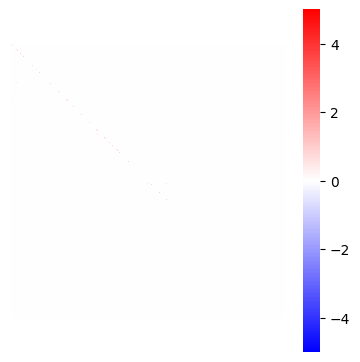

In [21]:
my_msm = sh_traj.get_transition_model()
tp = TransitionPlot(my_msm)
tp.plot_heatmap(0, save=False)
plt.show()